In [10]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

#Setting Random Seed
tf.random.set_seed(195470)

def load_Fashion_MNIST_with_noise(plot_show=False):

  (x_train, _), (x_test, _) = fashion_mnist.load_data()
  # Normalize train and test data
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.

  # Reshape so that each instance is a linear array of 784 normalized pixel values
  x_train = x_train.reshape((len(x_train), 784))
  x_test = x_test.reshape((len(x_test), 784))
  print (x_train.shape, x_test.shape)

  # Add random noise to the image
  noise_factor = 0.2
  x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
  x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

  # Clip the resulting values so that they don't fall outside the upper and lower normalized value of 0 and 1
  x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
  x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

  return x_train_noisy, x_train, x_test_noisy, x_test #tr_x, tr_y, te_x, te_y

In [11]:
#Function to plot images from the given data
def plot_images(te_x, te_y_pred, transpose = False , n = 10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      if transpose:
        plt.imshow(tf.transpose(te_x)[i].numpy().reshape(28, 28))
      else:
        plt.imshow(te_x[i].numpy().reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      if transpose:
        plt.imshow(tf.transpose(te_y_pred)[i].numpy().reshape(28, 28))
      else:
        plt.imshow(te_y_pred[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

In [12]:
#  push a matrix of feature data through the neural network and the final sigmoid layer
def forward_pass(x, w_1, b1, w_2, b2, w_3, b3, w_4, b4, w_5, b5, w_6, b6):

    # First Layer
    A1 = tf.matmul(w_1, x) + b1 #WX + b
    H1 =  tf.keras.activations.relu(A1) #ReLu activation

    # Second Layer
    A2 = tf.matmul(w_2, H1) + b2 #WX + b
    H2 =  tf.keras.activations.relu(A2) #ReLu activation

    # Third Layer
    A3 = tf.matmul(w_3, H2) + b3 #WX + b
    H3 =  tf.keras.activations.relu(A3) #ReLu activation

    # Fourth Layer
    A4 = tf.matmul(w_4, H3) + b4 #WX + b
    H4 =  tf.keras.activations.relu(A4) #ReLu activation

    # Fifth Layer / Output Layer
    A5 = tf.matmul(w_5, H4) + b5 #WX + b
    H5 =  tf.keras.activations.relu(A5) #ReLu activation

    # Sixth Layer / Output Layer
    A6 = tf.matmul(w_6, H5) + b6 #WX + b
    #Sigmoid activation 1/1+e^-Z
    return tf.divide(tf.exp(A6),tf.add(1,tf.exp(A6))) # = e^z/(1+e^z)

In [13]:
def mean_absolute_error(y, y_pred):
  #Return mean absolute error
  return tf.reduce_mean(tf.cast(tf.abs(y - y_pred), tf.float32))

In [14]:
#Function to type cast to float32 by default
def fl_type_caster(x,t=tf.float32):
  return tf.cast(x,t)

(60000, 784) (10000, 784)


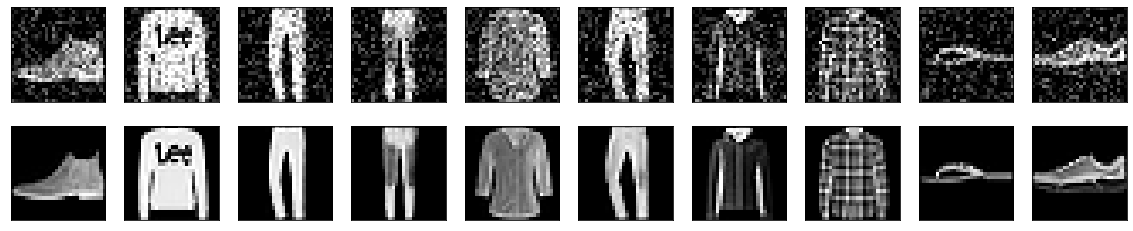

In [15]:
# load the prepared data and typecast the training and test data
tr_x, tr_y, te_x, te_y = [tf.transpose(fl_type_caster(i)) for i in load_Fashion_MNIST_with_noise(True)]
plot_images(te_x,te_y,True)

+---------------------+---------------------+---------------------+
|        Epoch        |    Training_loss    |   Validation_loss   |
+---------------------+---------------------+---------------------+
|          1          |       0.38393       |       0.38257       |
|          2          |       0.38262       |       0.38126       |
|          3          |       0.38158       |       0.38023       |
|          4          |       0.38029       |       0.37894       |
|          5          |       0.37849       |       0.37715       |
|          6          |       0.37603       |       0.37471       |
|          7          |       0.37281       |       0.37152       |
|          8          |       0.36874       |       0.36749       |
|          9          |       0.3638        |       0.36261       |
|         10          |       0.35805       |       0.35694       |
+---------------------+---------------------+---------------------+
|        Epoch        |    Training_loss    |   

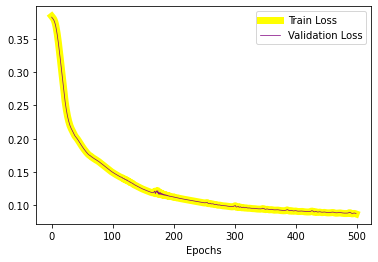

In [16]:
#No of iterations
epochs = 500

training_loss, validation_loss = [],[]

#Initializing the weights and biases for 1st layer 128N
w1 = tf.Variable(tf.random.normal([128, tr_x.shape[0]], mean=0.0, stddev=0.1))
b1 = tf.Variable(tf.zeros([128, 1]))

#Initializing the weights and biases for 2nd layer 64N
w2 = tf.Variable(tf.random.normal([64, 128], mean=0.0, stddev=0.1))
b2 = tf.Variable(tf.zeros([64, 1]))

#Initializing the weights and biases for 3rd layer 32N
w3 = tf.Variable(tf.random.normal([32, 64], mean=0.0, stddev=0.1))
b3 = tf.Variable(tf.zeros([32, 1]))

#Initializing the weights and biases for 4th layer 64N
w4 = tf.Variable(tf.random.normal([64, 32], mean=0.0, stddev=0.1))
b4 = tf.Variable(tf.zeros([64, 1]))

#Initializing the weights and biases for 5th layer 128N
w5 = tf.Variable(tf.random.normal([128, 64], mean=0.0, stddev=0.1))
b5 = tf.Variable(tf.zeros([128, 1]))

#Initialize the weights and biases for the 6th ie Output layer 784N
w6 = tf.Variable(tf.random.normal([tr_y.shape[0],128], mean=0.0, stddev=0.1))
b6 = tf.Variable(tf.zeros([tr_y.shape[0], 1]))

#Instantiate Optimizer
adam_optimizer = tf.keras.optimizers.Adam()

# Training loop
for i in range(epochs):
    if i%10 == 0:
      print("+-{:^19}-+-{:^19}-+-{:^19}-+".format("-"*19,"-"*19,"-"*19,"-"*19,"-"*19))
      print("| {:^19} | {:^19} | {:^19} |".format("Epoch","Training_loss","Validation_loss"))
      print("+-{:^19}-+-{:^19}-+-{:^19}-+".format("-"*19,"-"*19,"-"*19,"-"*19,"-"*19))

    # Instantiating Gradient Tape to monitor the forward pass & calculate gradients ie autodiff
    with tf.GradientTape() as tape:
        y_pred = forward_pass(tr_x, w1, b1, w2, b2, w3, b3, w4, b4, w5, b5, w6, b6)
        loss = mean_absolute_error(tr_y, y_pred)
    training_loss.append(loss)
    
    # Calculate gradients
    gradients = tape.gradient(loss, [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5, w6, b6])

    # Forward propagate and calculate accuracy and loss for the valdation data
    te_y_pred = forward_pass(te_x, w1, b1, w2, b2, w3, b3, w4, b4, w5, b5, w6, b6) 
    val_loss = mean_absolute_error(te_y, te_y_pred)
    validation_loss.append(val_loss)
    # print(loss.numpy,accuracy.numpy(),val_loss.numpy())
    print("| {:^19} | {:^19} | {:^19} |".format(i+1,round(float(loss.numpy()),5),round(float(val_loss.numpy()),5)))
    # print("Y",te_y.shape,"YPRED",te_y_pred.shape)
    # Adam Optimizer to update the weights and biases accordingly
    adam_optimizer.apply_gradients(zip(gradients, [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5, w6, b6]))

print("+-{:^19}-+-{:^19}-+-{:^19}-+".format("-"*19,"-"*19,"-"*19,"-"*19,"-"*19))

# Plot the training and the validation accuracy and loss
plt.plot(training_loss, label="Train Loss",color='yellow',linewidth=7)
plt.plot(validation_loss, label="Validation Loss",color='purple',linewidth=0.7)
plt.xlabel("Epochs")
plt.legend()
plt.show()



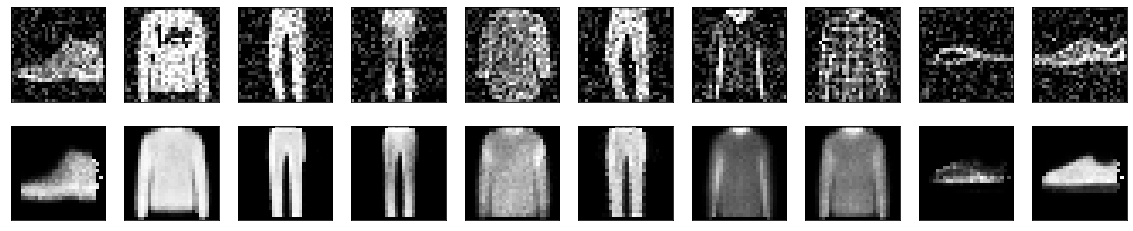

In [17]:
plot_images(te_x,te_y_pred,True)